# KMeans using cuML and Dask

Running kmeans using cuML and Dask for k=35 on a subset of the partitioned dataset, creating a dataframe with the cluster labels for each datapoint as well as their corresponding layer and head.

In [ ]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
# from cuml import DBSCAN as cumlDBSCAN
from cuml.dask.cluster.kmeans import KMeans as daskKMeans
from cuml.decomposition import PCA
import cupy

from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd

from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN
# from dask_cuml.cluster import DBSCAN as daskDBSCAN

In [6]:
output_dir='/rapids/notebooks/host/representations/output/'

In [7]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
client = Client(cluster)

In [8]:
def get_pd_labels(model, dask_df):
    kmeans_labels = trained_kmeans.predict(dask_df)
    kml_computed = kmeans_labels.compute()
    return kml_computed.to_pandas()

In [9]:
def location(index):
    example = int(index/144)
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    head = layer_head_location % 12
    return (example, layer, head)

In [10]:
def layer(index):
    layer_head_location = index % 144
    return int(layer_head_location/12)
    
def head(index):
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    return layer_head_location % 12

In [11]:
def index_layer_heads(df):
    df.rename(columns={0:'cluster'},inplace=True)
    df['layer'] = (df.index.to_series().apply(layer))
    df['head'] = (df.index.to_series().apply(head))
    return df

In [12]:
# note - using 'file://' prefix: https://github.com/rapidsai/cudf/issues/3017
gdf = dask_cudf.read_csv('file://../../representations/final/partitions/*.csv')

In [14]:
%%time
n_clusters = 35

kmeans_cuml = daskKMeans(
                       client=client,
                       init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=10,
                       random_state=42)

trained_kmeans = kmeans_cuml.fit(gdf)

CPU times: user 21.2 s, sys: 2.18 s, total: 23.4 s
Wall time: 6min 42s


In [15]:
#60_00.csv - 60_13.csv 7-21-20 00:31
torch.save(trained_kmeans, os.path.join(output_dir,'dask_kmeans_model.bin'))

In [16]:
pd_labels = get_pd_labels(trained_kmeans, gdf) #returns a pandas series

In [17]:
df_labels = pd.DataFrame(pd_labels)

In [18]:
df_labels = index_layer_heads(df_labels)

In [19]:
df_labels.head(20)

,cluster,layer,head
0,12,0,0
1,12,0,1
2,8,0,2
3,8,0,3
4,12,0,4
5,12,0,5
6,12,0,6
7,12,0,7
8,4,0,8
9,12,0,9


In [20]:
torch.save(df_labels, os.path.join(output_dir,'dask_kmeans_df_labels.bin'))

In [21]:
cluster_bylayer = df_labels.groupby(['cluster','layer']).count()

In [24]:
cluster_bylayer.tail(15)

head
cluster layer      
33      9      1620
        10     1588
        11     1631
34      0      2769
        1      2493
        2      2658
        3      2911
        4      2992
        5      3055
        6      3149
        7      3416
        8      3036
        9      2794
        10     3006
        11     3906

In [22]:
cluster_layer = df_labels.groupby(['cluster','head']).count()

In [23]:
cluster_layer.tail(15)

layer
cluster head       
33      9      1453
        10     1333
        11     1216
34      0      3002
        1      2730
        2      2912
        3      2828
        4      2739
        5      3100
        6      3203
        7      3044
        8      3165
        9      2956
        10     3198
        11     3308

/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

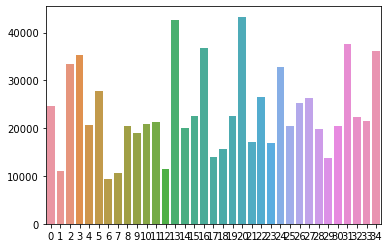

In [25]:
label_count = df_labels['cluster'].value_counts()

x = label_count.index
y = label_count.values

sns.barplot(x, y)

<AxesSubplot:xlabel='cluster'>

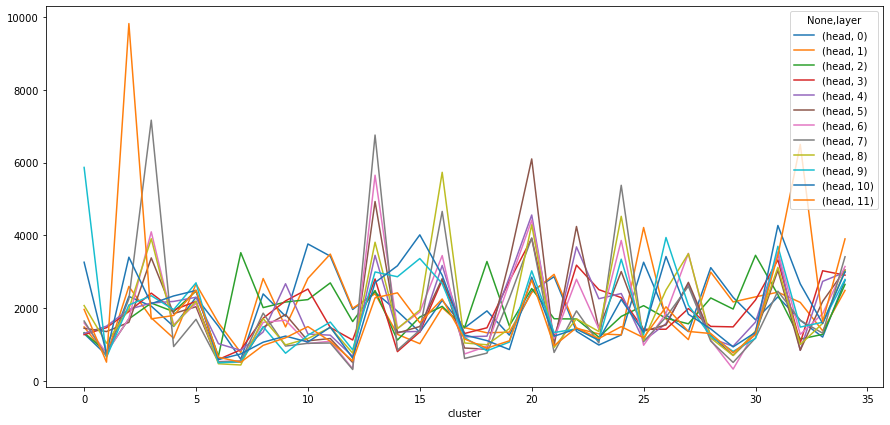

In [26]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_labels.groupby(['cluster','layer']).count().unstack().plot(ax=ax)

<AxesSubplot:xlabel='cluster'>

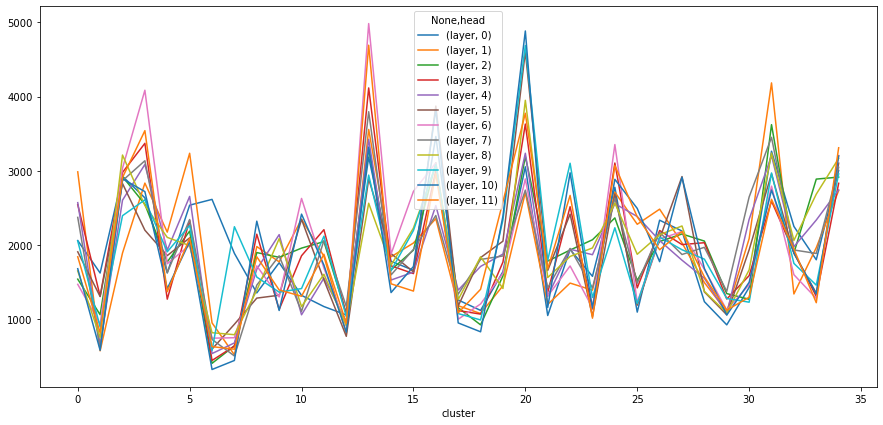

In [27]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_labels.groupby(['cluster','head']).count().unstack().plot(ax=ax)
